In [ ]:
import sys,os
sys.path.append('.')
sys.path.append('/home/lev/slot_attention/')
import torch
from typing import Optional

import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision import transforms

from slot_attention.data import CLEVRDataModule, ESC50DataModule, SyntaticDataModule
from slot_attention.method import SlotAttentionMethod
from slot_attention.model import SlotAttentionModel
from slot_attention.params import SlotAttentionParams
from slot_attention.utils import ImageLogCallback
from slot_attention.utils import rescale, normalize_audio

import hydra 
import wandb
from omegaconf import DictConfig, OmegaConf

import logging

import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"


def get_dataset(cfg:DictConfig):
    if "_dataset" in cfg.dataset.name:   
        return SyntaticDataModule(cfg)

    elif cfg.dataset.name == 'esc50':
        clevr_transforms = transforms.Compose(
        [
            transforms.Lambda(normalize_audio)
        ])

        return ESC50DataModule(cfg=cfg, clevr_transforms=clevr_transforms)
    elif cfg.dataset.name == 'clever':
        clevr_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(rescale),  # rescale between -1 and 1
            transforms.Resize(tuple(cfg.model.resolution)),
        ]

         )

        clevr_datamodule = CLEVRDataModule(
            data_root=cfg.dataset.data_root,
            max_n_objects=cfg.model.num_slots - 1,
            train_batch_size=cfg.dataset.train_batch_size,
            val_batch_size=cfg.dataset.val_batch_size,
            clevr_transforms=clevr_transforms, # change also this moment))
            num_train_images=cfg.dataset.num_train_images,
            num_val_images=cfg.dataset.num_val_images,
            num_workers=cfg.dataset.num_workers,
        )
        return clevr_datamodule
    else: 
        print('Choose the dataset')
        
    




def main(cfg):
    assert cfg.model.num_slots > 1, "Must have at least 2 slots."

    if cfg.additional.is_verbose:
        print(f"INFO: limiting the dataset to only images with `num_slots - 1` ({cfg.model.num_slots - 1}) objects.")
        if cfg.dataset.num_train_images:
            print(f"INFO: restricting the train dataset size to `num_train_images`: {cfg.dataset.num_train_images}")
        if cfg.dataset.num_val_images:
            print(f"INFO: restricting the validation dataset size to `num_val_images`: {cfg.dataset.num_val_images}")

 
    
    clevr_datamodule = get_dataset(cfg)

    print(f"Training set size (images must have {cfg.model.num_slots - 1} objects):", len(clevr_datamodule.train_dataset))

    model = SlotAttentionModel(
        cfg=cfg
    )

    method = SlotAttentionMethod(model=model, datamodule=clevr_datamodule, hparams=cfg)
    return method, clevr_datamodule

# from hydra import compose, initialize
# from omegaconf import OmegaConf

# with initialize(config_path="../buffer/configs_benchmark", job_name="test_app"):
#     cfg = compose(config_name="default", overrides=[]) #clever_benchmark
    
# method, clevr_datamodule = main(cfg)
# print(OmegaConf.to_yaml(cfg))

In [ ]:

checkpoint_path="/home/lev/slot_attention/outputs/2021-12-01/clever_model_100epoch/slot-attention-search/1ci43d71/checkpoints/epoch=99-step=27299.ckpt"
data = torch.load(checkpoint_path)
method.load_state_dict(data['state_dict'])
method.eval()
print('1')

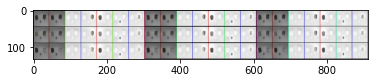

In [73]:
for batch in clevr_datamodule.val_dataset:

    batch = batch.unsqueeze(0)
    break

recon_combined, recons, masks, slots = method(batch)


from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
# combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
out = to_rgb_from_tensor(
    torch.cat(
        [
            batch.unsqueeze(1),  # original images
            recon_combined.unsqueeze(1),  # reconstructions
            recons * masks + (1 - masks),  # each slot
        ],
        dim=1,
    )
)

batch_size, num_slots, C, H, W = recons.shape
images = vutils.make_grid(
    out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1],
)
ch, h, w = images.shape
plt.imshow(images.reshape(h, w, ch))

### Trained model

In [147]:
from collections import defaultdict
for batch in clevr_datamodule.val_dataloader():
    #batch = batch.unsqueeze(0)
    enc_out = method.model.encoder(batch)
    
    for num_iter in range(1,100,5):
        method.model.slot_attention.num_iterations = num_iter
        a = method.model.slot_attention(enc_out)
        d[num_iter].append(torch.mean(torch.cdist(a,a)).detach().cpu().numpy())

stat = defaultdict(list)
for key in d.keys():
    stat[key] = (np.mean(d[key]), np.std(d[key]))

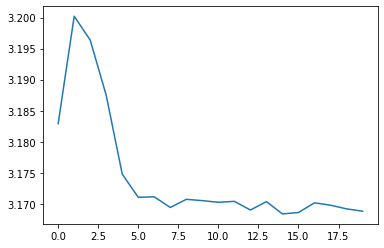

In [150]:
plt.plot([stat[key][0] for key in stat.keys()])

In [148]:
stat

defaultdict(list,
            {1: (3.1829216, 0.32730198),
             11: (3.2002027, 0.23927523),
             21: (3.196365, 0.24338873),
             6: (3.1874735, 0.09147124),
             16: (3.174796, 0.091090724),
             26: (3.171074, 0.09050416),
             31: (3.1711473, 0.090620056),
             36: (3.1694376, 0.0900788),
             41: (3.170745, 0.09101931),
             46: (3.1705365, 0.09094098),
             51: (3.1702714, 0.09107486),
             56: (3.1704202, 0.08918924),
             61: (3.1690266, 0.09200098),
             66: (3.1703765, 0.09046828),
             71: (3.1683993, 0.09153337),
             76: (3.1686213, 0.090385996),
             81: (3.1701844, 0.08966272),
             86: (3.1698034, 0.090795465),
             91: (3.1692166, 0.09089355),
             96: (3.1688397, 0.089721836)})

### Random initialization 

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414


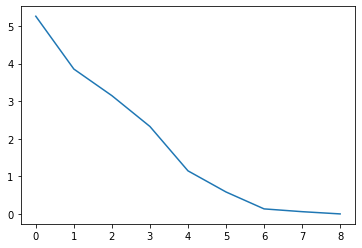

In [166]:
# random weights 
method, clevr_datamodule = main(cfg)
method.to(torch.device('cuda'))
d = defaultdict(list)
for batch in clevr_datamodule.val_dataloader():
    #batch = batch.unsqueeze(0)
    enc_out = method.model.encoder(batch.to(torch.device('cuda')))
    
    for num_iter in [1,2,3,5,10,15,25,30,100]:
        method.model.slot_attention.num_iterations = num_iter
        a = method.model.slot_attention(enc_out)
        d[num_iter].append(torch.mean(torch.cdist(a,a)).detach().cpu().numpy())

stat = defaultdict(list)
for key in d.keys():
    stat[key] = (np.mean(d[key]), np.std(d[key]))
plt.plot([stat[key][0] for key in stat.keys()])


In [167]:
stat


defaultdict(list,
            {1: (5.2577004, 0.037303507),
             2: (3.8533564, 0.02743584),
             3: (3.14545, 0.028228633),
             5: (2.3254793, 0.029923445),
             10: (1.1456108, 0.025593022),
             15: (0.58353627, 0.017609676),
             25: (0.13371673, 0.005113261),
             30: (0.059651136, 0.0026299544),
             100: (8.106775e-07, 1.5723243e-08)})

### Pretrained encoder +  Slot random weights

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414
INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414
1


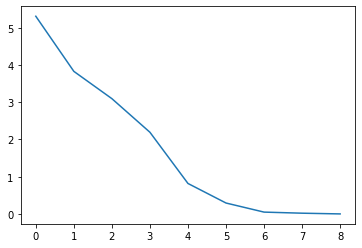

In [168]:
# random weights 
method1, clevr_datamodule = main(cfg)
method1.to(torch.device('cuda')).eval()

# pretrained encoder
method2, clevr_datamodule = main(cfg)

checkpoint_path="/home/lev/slot_attention/outputs/2021-12-01/clever_model_100epoch/slot-attention-search/1ci43d71/checkpoints/epoch=99-step=27299.ckpt"
data = torch.load(checkpoint_path)
method2.load_state_dict(data['state_dict'])
method2.to(torch.device('cuda')).eval()
print('1')


method.to(torch.device('cuda'))
d = defaultdict(list)
for batch in clevr_datamodule.val_dataloader():
    #batch = batch.unsqueeze(0)
    enc_out = method2.model.encoder(batch.to(torch.device('cuda')))
    
    for num_iter in [1,2,3,5,10,15,25,30,100]:
        method1.model.slot_attention.num_iterations = num_iter
        a = method1.model.slot_attention(enc_out)
        d[num_iter].append(torch.mean(torch.cdist(a,a)).detach().cpu().numpy())

stat = defaultdict(list)
for key in d.keys():
    stat[key] = (np.mean(d[key]), np.std(d[key]))
plt.plot([stat[key][0] for key in stat.keys()])


### Slot retrained  +  Encoder random weights

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414
INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414
1


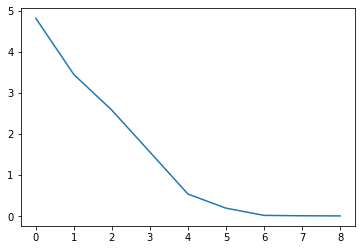

In [169]:
# random weights 
method1, clevr_datamodule = main(cfg)
method1.to(torch.device('cuda')).eval()

# pretrained encoder
method2, clevr_datamodule = main(cfg)

checkpoint_path="/home/lev/slot_attention/outputs/2021-12-01/clever_model_100epoch/slot-attention-search/1ci43d71/checkpoints/epoch=99-step=27299.ckpt"
data = torch.load(checkpoint_path)
method2.load_state_dict(data['state_dict'])
method2.to(torch.device('cuda')).eval()
print('1')


method.to(torch.device('cuda'))
d = defaultdict(list)
for batch in clevr_datamodule.val_dataloader():
    #batch = batch.unsqueeze(0)
    enc_out = method1.model.encoder(batch.to(torch.device('cuda')))
    
    for num_iter in [1,2,3,5,10,15,25,30,100]:
        method2.model.slot_attention.num_iterations = num_iter
        a = method2.model.slot_attention(enc_out)
        d[num_iter].append(torch.mean(torch.cdist(a,a)).detach().cpu().numpy())

stat = defaultdict(list)
for key in d.keys():
    stat[key] = (np.mean(d[key]), np.std(d[key]))
plt.plot([stat[key][0] for key in stat.keys()])


In [83]:
from hydra import compose, initialize
from omegaconf import OmegaConf


with initialize(config_path="../slot_attention/configs", job_name="test_app"):
    cfg = compose(config_name="default", overrides=[])
    
method, clevr_datamodule = main(cfg)
checkpoint_path="/home/lev/slot_attention/outputs/2021-12-09/20-00-00/implicit_experiments/2619mscn/checkpoints/epoch=99-step=27298.ckpt"
data = torch.load(checkpoint_path)
method.load_state_dict(data['state_dict'])
method.to(torch.device('cuda')).eval()
print('1')
#

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414
1


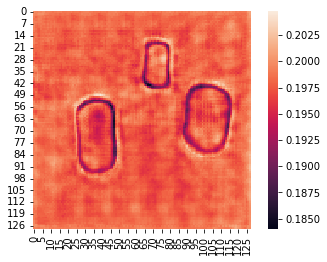

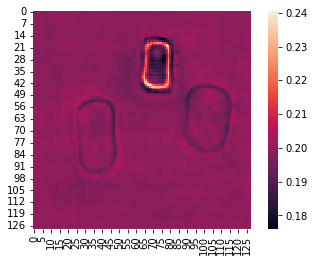

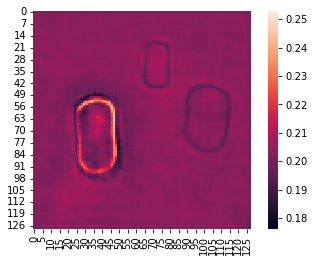

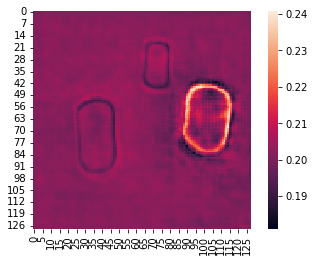

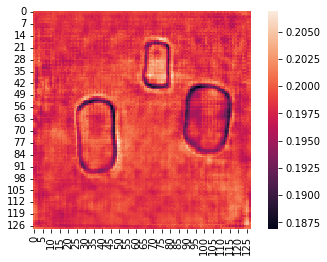

In [90]:
from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
for i, batch in enumerate(clevr_datamodule.val_dataset):
    if i == 2:
        
    
        batch = batch.unsqueeze(0).to(torch.device('cuda'))
        break

recon_combined, recons, masks, slots = method(batch)



# combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
# combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
out = to_rgb_from_tensor(
    torch.cat(
        [
            batch.unsqueeze(1),  # original images
            recon_combined.unsqueeze(1),  # reconstructions
            recons * masks + (1 - masks),  # each slot
        ],
        dim=1,
    )
)

batch_size, num_slots, C, H, W = recons.shape
images = vutils.make_grid(
    out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1],
)
ch, h, w = images.shape
plt.imshow(images.reshape(h, w, ch))

data =  masks.squeeze(0).cpu().detach().numpy()
for idx in range(len(data)):
    plt.imshow(data[idx,0], cmap='hot')

    ax = sns.heatmap(data[idx,0])
    plt.show()

In [80]:
batch.shape

torch.Size([1, 3, 128, 128])

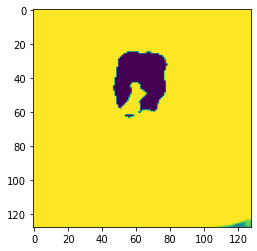

In [57]:
plt.imshow(data[idx,0])

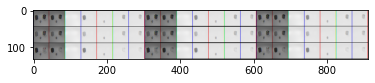

In [87]:
for batch in clevr_datamodule.val_dataset:

    batch = batch.unsqueeze(0).to(torch.device('cuda'))
    break

recon_combined, recons, masks, slots = method(batch)


from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
# combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
out = to_rgb_from_tensor(
    torch.cat(
        [
            batch.unsqueeze(1),  # original images
            recon_combined.unsqueeze(1),  # reconstructions
            recons * masks + (1 - masks),  # each slot
        ],
        dim=1,
    )
)

batch_size, num_slots, C, H, W = recons.shape
images = vutils.make_grid(
    out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1],
)
ch, h, w = images.shape
plt.imshow(images.reshape(h, w, ch))

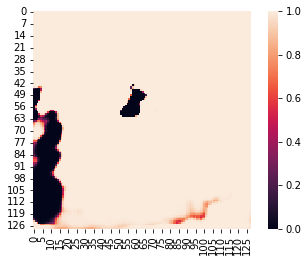

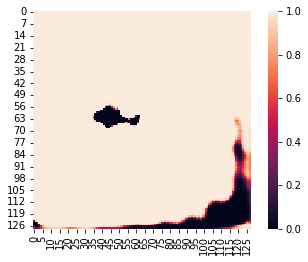

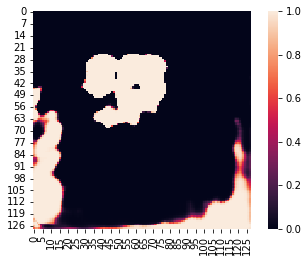

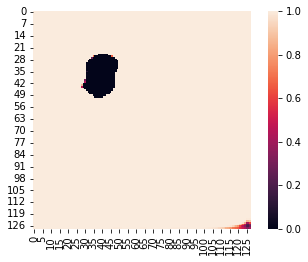

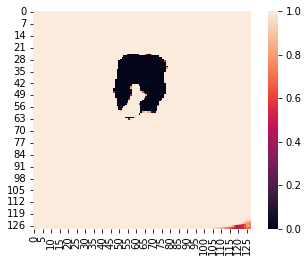

In [53]:
import seaborn as sns
data = 1 - masks.squeeze(0).cpu().detach().numpy()
for idx in range(len(data)):
    plt.imshow(data[idx,0], cmap='hot')

    ax = sns.heatmap(data[idx,0])
    plt.show()